# CNN - сверточная нейронная сеть

Формула для свертки

---
## Вектор:
$$
o = \left\lfloor \frac{n + 2p - m}{s} \right\rfloor + 1.
$$

---

## 📐 Формулы размера выхода при 2D-свёртке

Пусть:

| Символ | Обозначение |
|--------|-------------|
| `H`    | Высота входного изображения (число строк) |
| `W`    | Ширина входного изображения (число столбцов) |
| `K_h`  | Высота ядра (фильтра) — по вертикали |
| `K_w`  | Ширина ядра (фильтра) — по горизонтали |
| `P_h`  | Padding по высоте — число нулей сверху и снизу |
| `P_w`  | Padding по ширине — число нулей слева и справа |
| `S_h`  | Stride по высоте — шаг сдвига фильтра по вертикали |
| `S_w`  | Stride по ширине — шаг сдвига фильтра по горизонтали |
| `O_h`  | Высота выходного изображения |
| `O_w`  | Ширина выходного изображения |

---

## 🔢 Основные формулы:

$$
O_h = \left\lfloor \frac{H + 2P_h - K_h}{S_h} \right\rfloor + 1
$$

$$
O_w = \left\lfloor \frac{W + 2P_w - K_w}{S_w} \right\rfloor + 1
$$

---

## 💡 Частный случай — квадратные изображения и ядра:

Если $ H = W = n $, $ K_h = K_w = m $, $ P_h = P_w = p $, $ S_h = S_w = s $, то:

$$
o = \left\lfloor \frac{n + 2p - m}{s} \right\rfloor + 1
$$

---

Действие `[*]` - это операция `floor`, она возвращает наиб. число для входного значения *, например `floor(1.77) -> [1.77] -> 1`

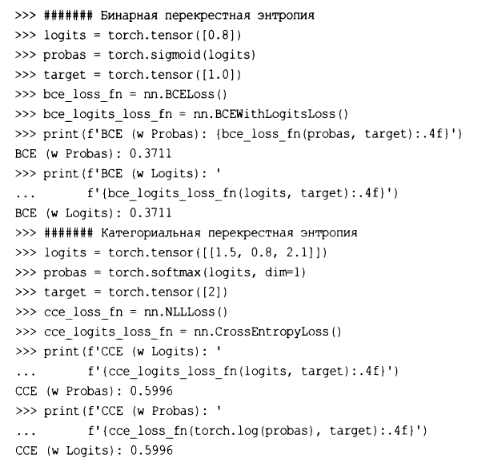

# Архитектура будущей сети
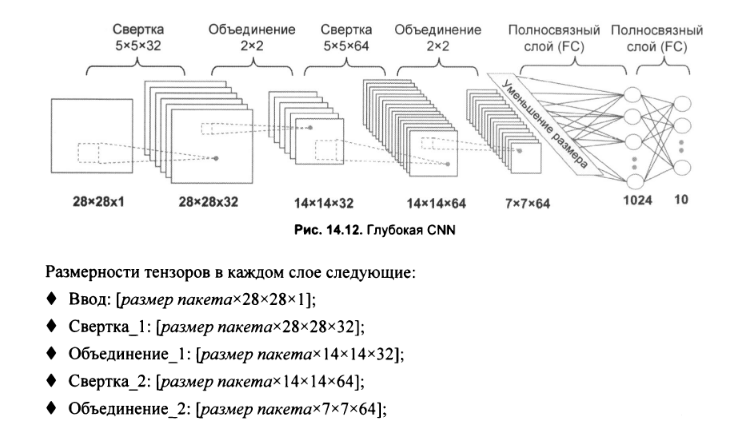

И последние полносвязанные слои <br>
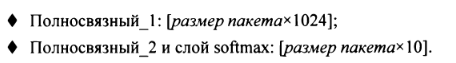

In [37]:
import torch
import torchvision

In [38]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [39]:
image_path = r'../.'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(image_path, train=True, transform=transform, download=False)

In [40]:
from torch.utils.data import Subset

In [41]:
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))    # Первые 10'000 записей
mnist_train_dataset= Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(image_path, train=False, transform=transform, download=False)

In [42]:
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=True)

test_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=True)

# Создание модели

**Важно**, что слои *Conv2d* в *Pytorch* принимают данные в формате: `NCWH - number, channel, width, height`

In [43]:
import torch.nn as nn 

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [59]:
model = nn.Sequential()

## Сверточные слои Conv Layers
# Первый блок
# II: n, 1, 28, 28
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu', nn.ReLU())
model.add_module('pool', nn.MaxPool2d(kernel_size=2))
# OUT: n, 1, 14, 14 

# Второй блок
# IN: n, 1, 14, 14
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
# OUT: n, 1, 7, 7

# Слой расжатия
model.add_module('flatten', nn.Flatten())

## Полносвязные слои FullyConnected Layers
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=.5))   # DROPOUT layer
model.add_module('fc2', nn.Linear(1024, 10))

model = model.to(device)

In [60]:
loss_fn = nn.CrossEntropyLoss()    # nn.CrossEntropyLoss() уже содержит softmax()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

## Обучение

In [ ]:
def train_model(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()    # Перевожу в режим обучения
        
        for x_batch, y_batch in train_dl:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred = model(x_batch)    # return probas
            loss = loss_fn(pred, y_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
            
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()    # Перевожу в режим оценки
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = model(x_batch)    # return probas
                loss = loss_fn(pred, y_batch)
                
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'{epoch+1}/{num_epochs}, train_accuracy: {accuracy_hist_train[epoch]:.3f}, train_loss: {loss_hist_train[epoch]:.3f}, valid_accuracy: {accuracy_hist_valid[epoch]:.3f}, valid_loss: {loss_hist_valid[epoch]:.3f}')
    
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
            
    

In [62]:
torch.manual_seed(1)
num_epochs = 20
hist = train_model(model, num_epochs, train_dl, valid_dl)

1 epoch, train_accuracy: 0.953, train_loss: 0.150,
 valid_accuracy: 0.983, valid_loss: 0.059
2 epoch, train_accuracy: 0.985, train_loss: 0.046,
 valid_accuracy: 0.986, valid_loss: 0.048
3 epoch, train_accuracy: 0.990, train_loss: 0.032,
 valid_accuracy: 0.989, valid_loss: 0.036
4 epoch, train_accuracy: 0.992, train_loss: 0.026,
 valid_accuracy: 0.988, valid_loss: 0.041
5 epoch, train_accuracy: 0.994, train_loss: 0.020,
 valid_accuracy: 0.989, valid_loss: 0.039
6 epoch, train_accuracy: 0.994, train_loss: 0.018,
 valid_accuracy: 0.990, valid_loss: 0.034
7 epoch, train_accuracy: 0.996, train_loss: 0.013,
 valid_accuracy: 0.991, valid_loss: 0.037
8 epoch, train_accuracy: 0.996, train_loss: 0.013,
 valid_accuracy: 0.989, valid_loss: 0.047
9 epoch, train_accuracy: 0.997, train_loss: 0.010,
 valid_accuracy: 0.991, valid_loss: 0.039
10 epoch, train_accuracy: 0.997, train_loss: 0.011,
 valid_accuracy: 0.991, valid_loss: 0.040
11 epoch, train_accuracy: 0.997, train_loss: 0.009,
 valid_accuracy: 

## Оценка модели

In [64]:
import matplotlib.pyplot as plt
import numpy as np

In [79]:
accuracy_hist_train_cpu, accuracy_hist_valid_cpu = zip(*[(t1.cpu(), t2.cpu()) for t1, t2 in zip(hist[2], hist[3])])

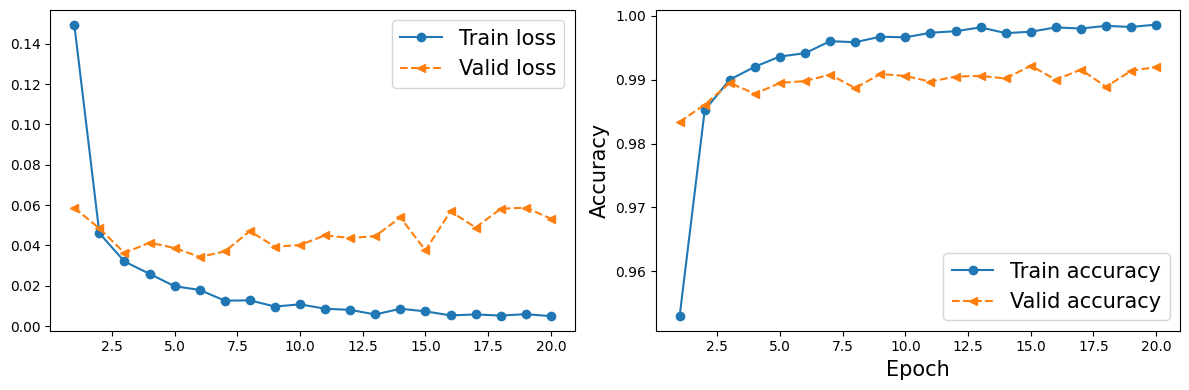

In [77]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Valid loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, accuracy_hist_train_cpu, '-o', label='Train accuracy')
ax.plot(x_arr, accuracy_hist_valid_cpu, '--<', label='Valid accuracy')
ax.legend(fontsize=15)

ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.tight_layout()
plt.show()

[tensor(0.9530, device='cuda:0'),
 tensor(0.9852, device='cuda:0'),
 tensor(0.9900, device='cuda:0'),
 tensor(0.9920, device='cuda:0'),
 tensor(0.9936, device='cuda:0'),
 tensor(0.9942, device='cuda:0'),
 tensor(0.9960, device='cuda:0'),
 tensor(0.9959, device='cuda:0'),
 tensor(0.9967, device='cuda:0'),
 tensor(0.9966, device='cuda:0'),
 tensor(0.9974, device='cuda:0'),
 tensor(0.9976, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9973, device='cuda:0'),
 tensor(0.9975, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9980, device='cuda:0'),
 tensor(0.9984, device='cuda:0'),
 tensor(0.9983, device='cuda:0'),
 tensor(0.9986, device='cuda:0')]

# Распознавание улыбок